# CONEXIÓN a API DE BLUESKY

In [1]:
import requests

url = "https://bsky.social/xrpc/app.bsky.feed.getAuthorFeed"

url_se = "https://bsky.social/xrpc/com.atproto.server.createSession"
payload = {
  "identifier": "grupo18.bsky.social",
  "password":'Grupo18*BS'
}
response_tk = requests.post(url_se, json=payload)
response_tk.raise_for_status()
token = response_tk.json()["accessJwt"]  # Token de acceso


## Búsqueda de actores por palabras clave

In [2]:
# --- Celda 2: Búsqueda de Múltiples Actores ---
import requests
import pandas as pd

# Lista de términos de búsqueda para los actores
''' search_terms = ["elpais", "bloomberg", "reuters", "apnews", "aoc", "theguardian", "washingtonpost", "nytimes", 
                "economist", "eldiario", "elpais", "lavanguardia", 
                "infobae", "lanacion", "clarin", "barchart", "wired", "unusualwhales"] # Ejemplo: Puedes cambiar esta lista'''

# Lista de términos de búsqueda para los actores
search_terms = ["bloomberg", "aoc", "economist", "wired", "theguardian", "unusualwhales", "nytimes", "barchart"
                ,"dacemoglumit","mclem", "arindube", "paulgp", "goolsbee", "byheatherlong", "claudia-sahm"]

# URL del endpoint de búsqueda de actores
search_url = "https://bsky.social/xrpc/app.bsky.actor.searchActors"

# Headers con el token de autenticación (Asegúrate que 'token' existe de la celda 1)
headers = {
    "Authorization": f"Bearer {token}"
}

found_actors = []
# ----- AQUÍ SE DECLARA LA LISTA VACÍA -----
actor_handles = []

print("Buscando actores...")
for term in search_terms:
    print(f"- Buscando '{term}'...")
    params = {
        "term": term,
        "limit": 1 # Buscamos solo el resultado más relevante por término
    }
    try:
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_data = response.json()

        if search_data['actors']:
            actor = search_data['actors'][0] # Tomamos el primer resultado
            print(f"  Encontrado: {actor['handle']} ({actor.get('displayName', 'N/A')})")
            actor_info = {
                'search_term': term,
                'did': actor['did'],
                'handle': actor['handle'],
                'display_name': actor.get('displayName', ''),
                'description': actor.get('description', ''),
            }
            found_actors.append(actor_info)
            # ----- AQUÍ SE LLENA LA LISTA -----
            actor_handles.append(actor['handle'])
        else:
            print(f"  No se encontraron resultados para '{term}'.")

    except requests.exceptions.RequestException as e:
        print(f"  Error buscando '{term}': {e}")

# Crear y mostrar DataFrame de actores encontrados
if found_actors:
    df_found_actors = pd.DataFrame(found_actors)
    print("\nActores encontrados:")
    display(df_found_actors[['search_term', 'handle', 'display_name']])
else:
    print("\nNo se encontraron actores para los términos de búsqueda.")

# Eliminar duplicados si los hubiera
actor_handles = list(set(actor_handles))
print(f"\nHandles únicos a procesar: {actor_handles}") # Esta lista se usará en la siguiente celda

Buscando actores...
- Buscando 'bloomberg'...
  Encontrado: bloomberg.com (Bloomberg News)
- Buscando 'aoc'...
  Encontrado: aoc.bsky.social (Alexandria Ocasio-Cortez)
- Buscando 'economist'...
  Encontrado: economist.com (The Economist)
- Buscando 'wired'...
  Encontrado: wired.com (WIRED )
- Buscando 'theguardian'...
  Encontrado: theguardian.com (The Guardian)
- Buscando 'unusualwhales'...
  Encontrado: unusualwhales.bsky.social (Unusual Whales)
- Buscando 'nytimes'...
  Encontrado: nytimes.com (The New York Times)
- Buscando 'barchart'...
  Encontrado: barchart.com (Barchart)
- Buscando 'dacemoglumit'...
  Encontrado: dacemoglumit.bsky.social (Daron Acemoglu)
- Buscando 'mclem'...
  Encontrado: mclem.org (Michael Clemens)
- Buscando 'arindube'...
  Encontrado: arindube.bsky.social (Arin Dube)
- Buscando 'paulgp'...
  Encontrado: paulgp.com (Paul Goldsmith-Pinkham)
- Buscando 'goolsbee'...
  Encontrado: goolsbee.bsky.social (Austan Goolsbee)
- Buscando 'byheatherlong'...
  Encontrad

,search_term,handle,display_name
0,bloomberg,bloomberg.com,Bloomberg News
1,aoc,aoc.bsky.social,Alexandria Ocasio-Cortez
2,economist,economist.com,The Economist
3,wired,wired.com,WIRED
4,theguardian,theguardian.com,The Guardian
5,unusualwhales,unusualwhales.bsky.social,Unusual Whales
6,nytimes,nytimes.com,The New York Times
7,barchart,barchart.com,Barchart
8,dacemoglumit,dacemoglumit.bsky.social,Daron Acemoglu
9,mclem,mclem.org,Michael Clemens



Handles únicos a procesar: ['claudia-sahm.bsky.social', 'aoc.bsky.social', 'paulgp.com', 'bloomberg.com', 'goolsbee.bsky.social', 'arindube.bsky.social', 'byheatherlong.bsky.social', 'nytimes.com', 'mclem.org', 'dacemoglumit.bsky.social', 'wired.com', 'barchart.com', 'economist.com', 'unusualwhales.bsky.social', 'theguardian.com']


## Obtengo el feed de múltiples actores

In [17]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import requests
import time

# --- Configuración ---
feed_url = "https://bsky.social/xrpc/app.bsky.feed.getAuthorFeed"
posts_limit_per_query = 100  # Máximo permitido por la API

# Obtener la fecha actual
current_date = datetime.now()

# Calcular start_date_str (hoy menos 5 días)
start_date_str = (current_date - timedelta(days=5)).strftime('%Y-%m-%d')

# Calcular end_date_str (hoy)
end_date_str = current_date.strftime('%Y-%m-%d')

# Convertir a datetime con timezone
start_date = datetime.strptime(start_date_str, '%Y-%m-%d').replace(tzinfo=timezone.utc)
end_date = datetime.strptime(end_date_str, '%Y-%m-%d').replace(tzinfo=timezone.utc)

all_posts = []
max_retries = 3  # Número máximo de reintentos por consulta

print(f"\nObteniendo feeds para {len(actor_handles)} actores entre {start_date.date()} y {end_date.date()}...")

if not actor_handles:
    print("No hay handles de actores para obtener feeds.")
else:
    for handle in actor_handles:
        print(f"\n--- Actor: {handle} ---")
        cursor = None  # Para paginación
        posts_found = 0
        has_more_posts = True
        retry_count = 0

        while has_more_posts and retry_count < max_retries:
            try:
                params = {
                    "actor": handle,
                    "limit": posts_limit_per_query
                }
                if cursor:
                    params["cursor"] = cursor

                response = requests.get(feed_url, headers=headers, params=params)
                response.raise_for_status()
                feed_data = response.json()
                feed_items = feed_data.get('feed', [])

                if not feed_items:
                    print(f"  No se encontraron más posts para {handle}")
                    break

                for item in feed_items:
                    post = item.get('post')
                    if not post or 'record' not in post:
                        continue

                    record = post.get('record', {})
                    created_at_str = record.get('createdAt', '')
                    if not created_at_str:
                        continue

                    try:
                        created_at_dt = datetime.fromisoformat(created_at_str.replace('Z', '+00:00'))
                    except ValueError:
                        continue

                    # Si el post es más antiguo que nuestro rango de fechas, detenemos la paginación
                    if created_at_dt < start_date:
                        has_more_posts = False
                        break

                    # Si el post está dentro de nuestro rango de fechas, lo guardamos
                    if start_date <= created_at_dt <= end_date:
                        post_data = {
                            'actor_handle': handle,
                            'uri': post.get('uri', ''),
                            'text': record.get('text', ''),
                            'created_at': created_at_dt,
                            'likes': post.get('likeCount', 0),
                            'reposts': post.get('repostCount', 0),
                            'replies': post.get('replyCount', 0)
                        }
                        all_posts.append(post_data)
                        posts_found += 1

                # Obtener el cursor para la siguiente página
                cursor = feed_data.get('cursor')
                if not cursor:
                    has_more_posts = False

                # Pequeña pausa para no sobrecargar la API
                time.sleep(0.5)

            except requests.exceptions.RequestException as e:
                print(f"  Error en la consulta a la API para {handle}: {e}")
                retry_count += 1
                if retry_count < max_retries:
                    print(f"  Reintentando... ({retry_count}/{max_retries})")
                    time.sleep(2)  # Esperar antes de reintentar
                else:
                    print(f"  Se alcanzó el máximo de reintentos para {handle}")
                    break

        print(f"  Posts encontrados para {handle}: {posts_found}")

# Crear DataFrame combinado con todos los posts
if all_posts:
    df = pd.DataFrame(all_posts)
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values(by='created_at', ascending=False).reset_index(drop=True)
    print("\nFeed combinado de todos los actores:")
    display(df.head())
    print(f"\nTotal de posts obtenidos: {len(df)}")
    print("\nDistribución por actor:")
    print(df['actor_handle'].value_counts())
else:
    print("\nNo se pudieron obtener posts de los actores en el rango de fechas.")
    df = pd.DataFrame(columns=['actor_handle', 'uri', 'text', 'created_at', 'likes', 'reposts', 'replies'])


Obteniendo feeds para 15 actores entre 2025-04-11 y 2025-04-16...

--- Actor: claudia-sahm.bsky.social ---
  Posts encontrados para claudia-sahm.bsky.social: 8

--- Actor: aoc.bsky.social ---
  Posts encontrados para aoc.bsky.social: 9

--- Actor: paulgp.com ---
  Posts encontrados para paulgp.com: 11

--- Actor: bloomberg.com ---
  Posts encontrados para bloomberg.com: 127

--- Actor: goolsbee.bsky.social ---
  Posts encontrados para goolsbee.bsky.social: 0

--- Actor: arindube.bsky.social ---
  Posts encontrados para arindube.bsky.social: 0

--- Actor: byheatherlong.bsky.social ---
  Posts encontrados para byheatherlong.bsky.social: 0

--- Actor: nytimes.com ---
  Posts encontrados para nytimes.com: 179

--- Actor: mclem.org ---
  Posts encontrados para mclem.org: 84

--- Actor: dacemoglumit.bsky.social ---
  Posts encontrados para dacemoglumit.bsky.social: 0

--- Actor: wired.com ---
  Posts encontrados para wired.com: 15

--- Actor: barchart.com ---
  Posts encontrados para barcha

,actor_handle,uri,text,created_at,likes,reposts,replies
0,barchart.com,at://did:plc:uf6xe5actjzjqqglrr5fvu7j/app.bsky...,S&P 500 companies are experiencing the worst e...,2025-04-15 23:58:34.305000+00:00,86,16,2
1,theguardian.com,at://did:plc:vovinwhtulbsx4mwfw26r5ni/app.bsky...,The return of the firing squad is a defeat for...,2025-04-15 23:28:41.295000+00:00,89,20,10
2,nytimes.com,at://did:plc:eclio37ymobqex2ncko63h4r/app.bsky...,Millions of people across Southern California ...,2025-04-15 23:12:31.800000+00:00,1015,149,66
3,aoc.bsky.social,at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky...,Thank YOU for coming out!\n\nThis is exactly w...,2025-04-15 23:06:41.062000+00:00,16833,1745,365
4,theguardian.com,at://did:plc:vovinwhtulbsx4mwfw26r5ni/app.bsky...,British hospitals introduce treatment for hear...,2025-04-15 23:05:06+00:00,270,67,4



Total de posts obtenidos: 987

Distribución por actor:
actor_handle
theguardian.com              443
nytimes.com                  179
bloomberg.com                127
mclem.org                     84
barchart.com                  56
unusualwhales.bsky.social     52
wired.com                     15
paulgp.com                    11
aoc.bsky.social                9
claudia-sahm.bsky.social       8
economist.com                  3
Name: count, dtype: int64


## Análisis preliminar aplicando minería de texto básica sobre el panda de posts obtenidos de BLUESKY

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


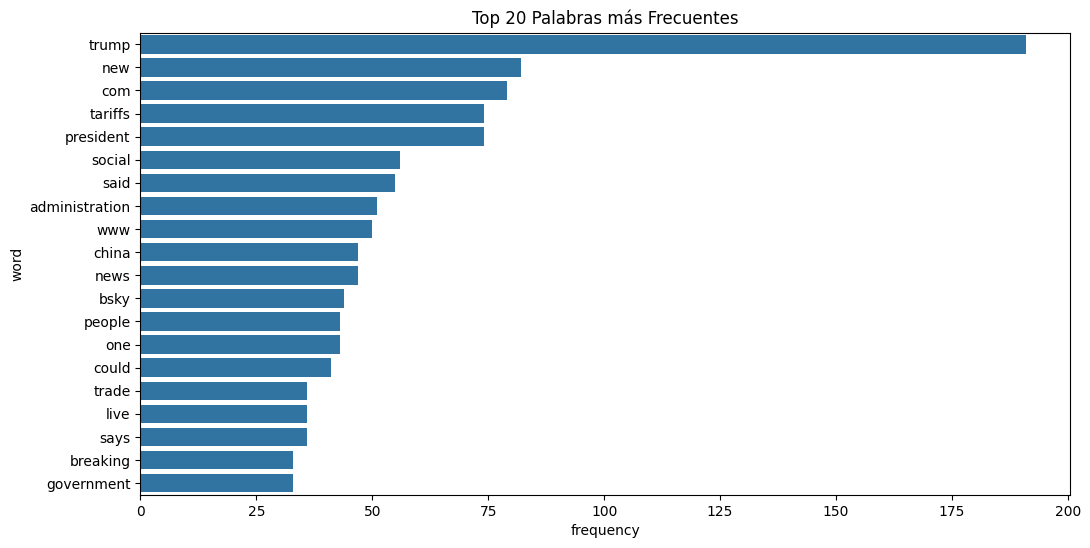


Frecuencia de palabras:


,word,frequency
0,trump,191
1,new,82
2,com,79
3,tariffs,74
4,president,74
5,social,56
6,said,55
7,administration,51
8,www,50
9,china,47


In [18]:
# Nueva celda para análisis de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Descargar todos los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def analyze_text(text_series):
    # Convertir a minúsculas y unir todos los textos
    all_text = ' '.join(text_series.str.lower())
    
    # Limpiar el texto de caracteres especiales y números
    all_text = re.sub(r'[^\w\s]', ' ', all_text)
    
    # Tokenizar el texto (usando un método más simple)
    tokens = all_text.split()
    
    # Eliminar stopwords y palabras cortas
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Contar frecuencia de palabras
    word_freq = Counter(filtered_tokens)
    
    # Crear DataFrame con las palabras más frecuentes
    df_word_freq = pd.DataFrame(word_freq.most_common(20), columns=['word', 'frequency'])
    
    # Visualizar las palabras más frecuentes
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_word_freq, x='frequency', y='word')
    plt.title('Top 20 Palabras más Frecuentes')
    plt.show()
    
    return df_word_freq

# Aplicar análisis al texto de los posts
word_frequency_df = analyze_text(df['text'])
print("\nFrecuencia de palabras:")
display(word_frequency_df)

## Análisis recomendado por el LLM de Cursos, a modo complementario al anterior


Estadísticas de Longitud de Posts:
       text_length  word_count
count   987.000000  987.000000
mean    133.899696   21.627153
std      78.343752   12.330259
min       0.000000    0.000000
25%      74.000000   12.000000
50%      97.000000   16.000000
75%     193.500000   31.000000
max     300.000000   55.000000


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


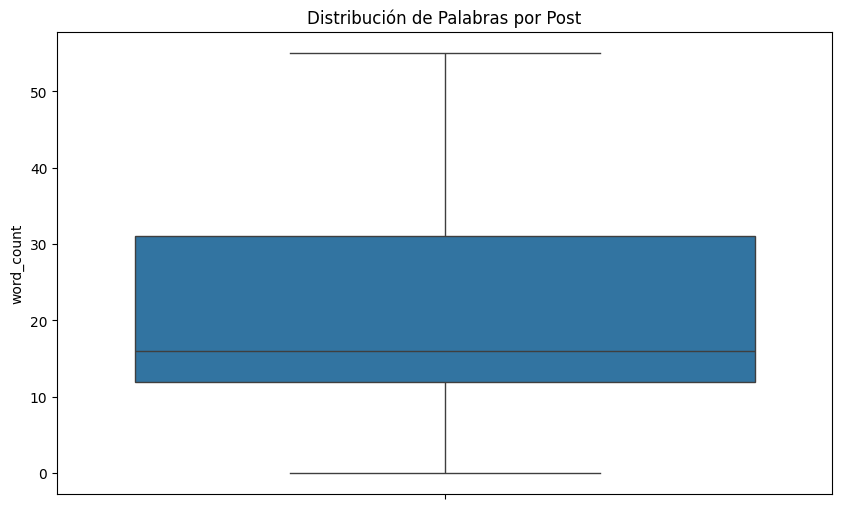

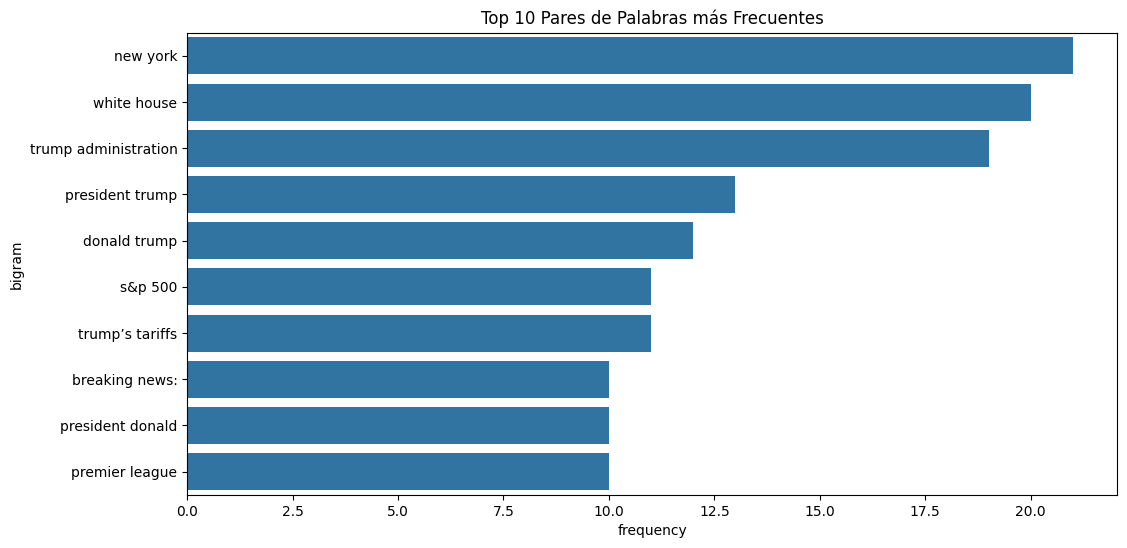

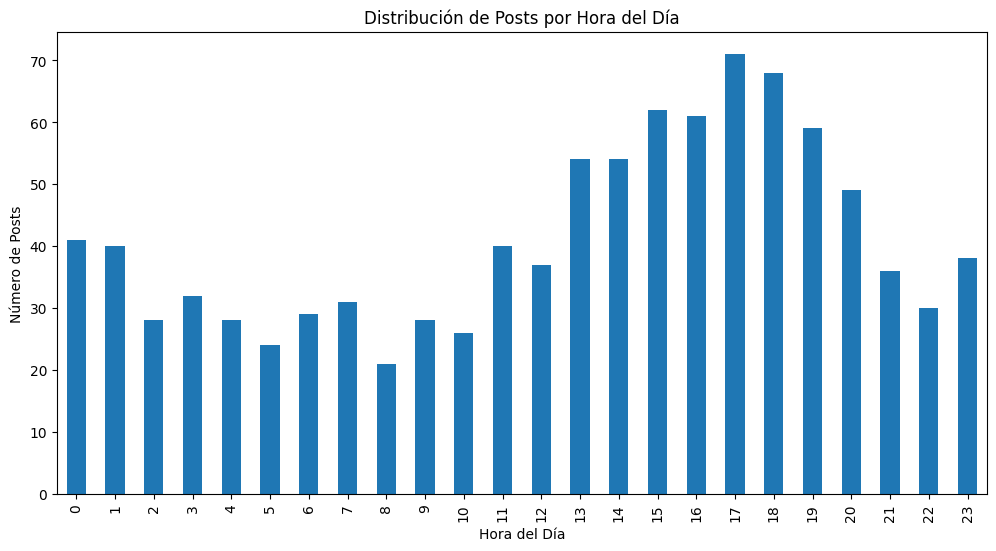


Hashtags más frecuentes:
[('#aifail', 1), ('#aiandthelaw', 1), ('#metoo', 1), ('#academicbluesky', 1), ('#academicfreedom', 1)]

Menciones más frecuentes:
[('@theathletic', 10), ('@nytopinion', 4), ('@pkrugman', 3), ('@aimeelucido', 2), ('@lhn', 2)]


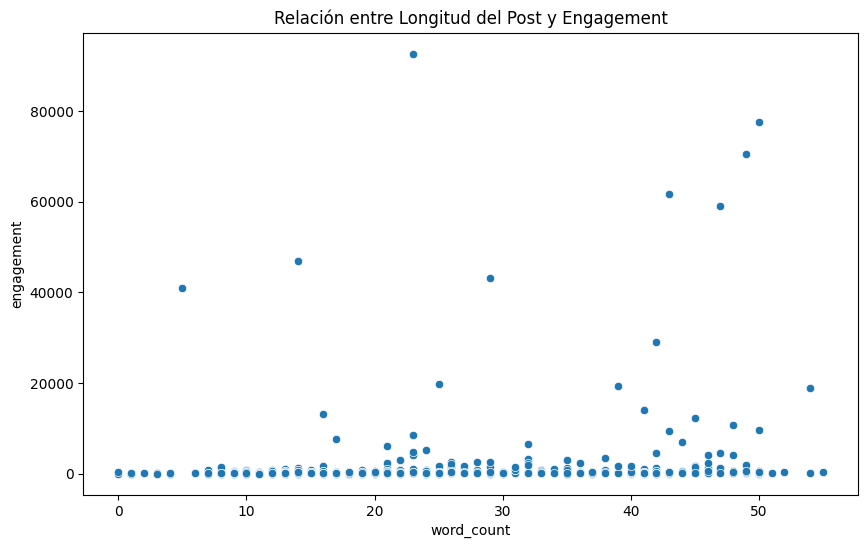


Palabras más frecuentes en posts de alto engagement:
[('trump', 99), ('president', 46), ('tariffs', 37), ('new', 33), ('trump’s', 32), ('said', 31), ('administration', 29), ('people', 25), ('china', 24), ('could', 23)]

Palabras más frecuentes en posts de bajo engagement:
[('new', 40), ('live', 27), ('president', 21), ('tariffs', 19), ('trump', 19), ('could', 17), ('says', 17), ('trump’s', 16), ('league', 15), ('since', 14)]


In [19]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import numpy as np

# Descargar recursos adicionales
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def analyze_text_patterns(text_series):
    # 1. Análisis de Longitud de Posts
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    print("\nEstadísticas de Longitud de Posts:")
    print(df[['text_length', 'word_count']].describe())
    
    # Visualización de longitud de posts
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df['word_count'])
    plt.title('Distribución de Palabras por Post')
    plt.show()
    
    # 2. Análisis de Bigramas (pares de palabras frecuentes)
    all_text = ' '.join(text_series.str.lower())
    words = all_text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    bigrams = list(ngrams(words, 2))
    bigram_freq = Counter(bigrams)
    
    # Visualizar bigramas más frecuentes
    plt.figure(figsize=(12, 6))
    bigram_df = pd.DataFrame(bigram_freq.most_common(10), columns=['bigram', 'frequency'])
    bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
    sns.barplot(data=bigram_df, x='frequency', y='bigram')
    plt.title('Top 10 Pares de Palabras más Frecuentes')
    plt.show()
    
    # 3. Análisis Temporal
    df['hour'] = df['created_at'].dt.hour
    hourly_posts = df.groupby('hour').size()
    
    plt.figure(figsize=(12, 6))
    hourly_posts.plot(kind='bar')
    plt.title('Distribución de Posts por Hora del Día')
    plt.xlabel('Hora del Día')
    plt.ylabel('Número de Posts')
    plt.show()
    
    # 4. Análisis de Hashtags y Menciones
    hashtags = re.findall(r'#\w+', all_text)
    mentions = re.findall(r'@\w+', all_text)
    
    print("\nHashtags más frecuentes:")
    print(Counter(hashtags).most_common(5))
    print("\nMenciones más frecuentes:")
    print(Counter(mentions).most_common(5))
    
    # 5. Análisis de Engagement
    df['engagement'] = df['likes'] + df['reposts'] + df['replies']
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='word_count', y='engagement')
    plt.title('Relación entre Longitud del Post y Engagement')
    plt.show()
    
    # 6. Análisis de Palabras Clave por Engagement
    high_engagement_posts = df[df['engagement'] > df['engagement'].median()]
    low_engagement_posts = df[df['engagement'] <= df['engagement'].median()]
    
    def get_top_words(posts, n=10):
        words = ' '.join(posts['text'].str.lower()).split()
        words = [word for word in words if word not in stop_words and len(word) > 2]
        return Counter(words).most_common(n)
    
    print("\nPalabras más frecuentes en posts de alto engagement:")
    print(get_top_words(high_engagement_posts))
    print("\nPalabras más frecuentes en posts de bajo engagement:")
    print(get_top_words(low_engagement_posts))
    
    return df

# Aplicar análisis
df = analyze_text_patterns(df['text'])

## Análisis de sentimiento

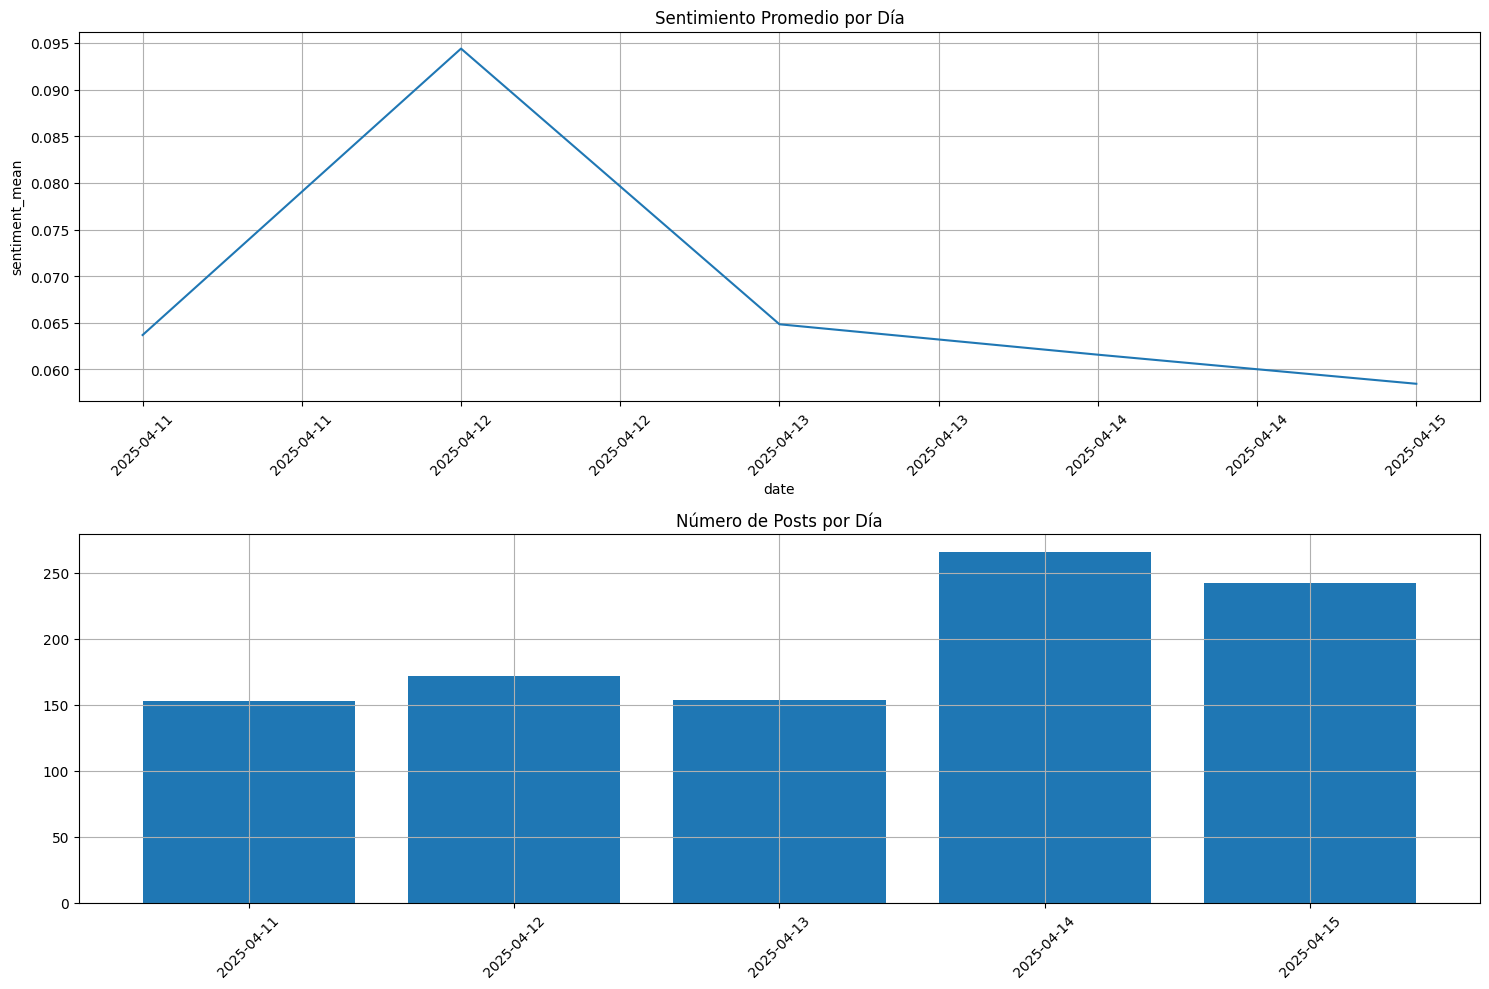


Estadísticas de Sentimiento por Día:
      date  sentiment_mean  post_count
2025-04-11        0.063693         153
2025-04-12        0.094399         172
2025-04-13        0.064845         154
2025-04-14        0.061585         266
2025-04-15        0.058468         242


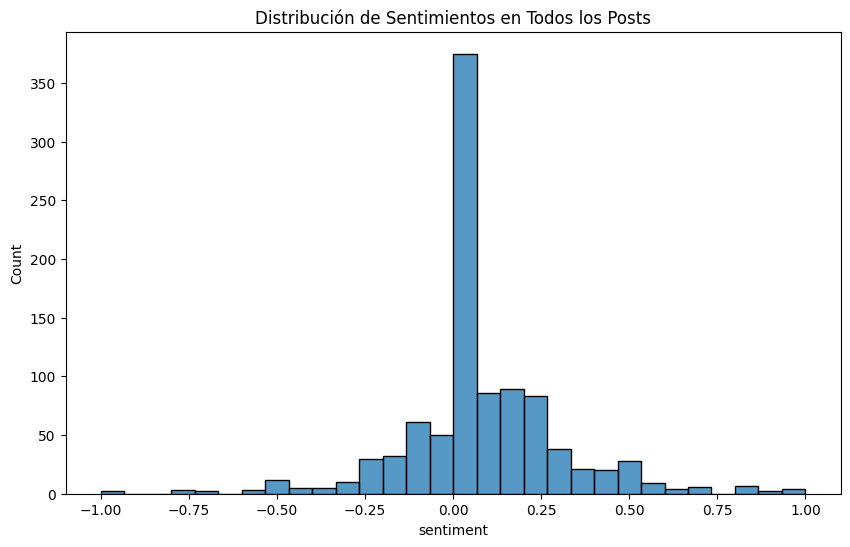


Estadísticas Generales de Sentimiento:
Sentimiento promedio general: 0.067
Posts positivos (>0.1): 336
Posts negativos (<-0.1): 118
Posts neutrales (-0.1 a 0.1): 533


In [20]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

def analyze_sentiment_by_day(df):
    # Convertir created_at a fecha (sin hora)
    df['date'] = df['created_at'].dt.date
    
    # Función para calcular el sentimiento
    def get_sentiment(text):
        try:
            return TextBlob(str(text)).sentiment.polarity
        except:
            return 0
    
    # Calcular sentimiento para cada post
    df['sentiment'] = df['text'].apply(get_sentiment)
    
    # Agrupar por fecha y calcular estadísticas
    daily_sentiment = df.groupby('date').agg({
        'sentiment': ['mean', 'count'],
        'text': lambda x: ' '.join(x)  # Unir todos los textos del día
    }).reset_index()
    
    # Renombrar columnas
    daily_sentiment.columns = ['date', 'sentiment_mean', 'post_count', 'daily_text']
    
    # Calcular sentimiento promedio del día
    daily_sentiment['daily_sentiment'] = daily_sentiment['daily_text'].apply(get_sentiment)
    
    # Crear visualizaciones
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Sentimiento promedio por día
    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    sns.lineplot(data=daily_sentiment, x='date', y='sentiment_mean')
    plt.title('Sentimiento Promedio por Día')
    
    # Formatear el eje X para mostrar fechas correctamente
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Gráfico 2: Número de posts por día
    plt.subplot(2, 1, 2)
    ax2 = plt.gca()
    
    # Convertir fechas a formato matplotlib
    dates = mdates.date2num(daily_sentiment['date'])
    
    # Crear el gráfico de barras con fechas
    plt.bar(dates, daily_sentiment['post_count'])
    
    # Formatear el eje X para mostrar fechas correctamente
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.title('Número de Posts por Día')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print("\nEstadísticas de Sentimiento por Día:")
    print(daily_sentiment[['date', 'sentiment_mean', 'post_count']].to_string(index=False))
    
    # Análisis adicional: Distribución de sentimientos
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sentiment', bins=30)
    plt.title('Distribución de Sentimientos en Todos los Posts')
    plt.show()
    
    # Calcular estadísticas generales
    print("\nEstadísticas Generales de Sentimiento:")
    print(f"Sentimiento promedio general: {df['sentiment'].mean():.3f}")
    print(f"Posts positivos (>0.1): {len(df[df['sentiment'] > 0.1])}")
    print(f"Posts negativos (<-0.1): {len(df[df['sentiment'] < -0.1])}")
    print(f"Posts neutrales (-0.1 a 0.1): {len(df[(df['sentiment'] >= -0.1) & (df['sentiment'] <= 0.1)])}")
    
    return daily_sentiment

# Aplicar el análisis
daily_sentiment_df = analyze_sentiment_by_day(df)

## Análisis de sentimiento por librería "vaderSentiment"

Ejecutando análisis de sentimiento VADER sobre TODOS los posts...
Calculando sentimiento VADER para cada post...
Cálculo de sentimiento individual completado.
Agrupando resultados por día...
Agrupación completada.
Generando visualizaciones...


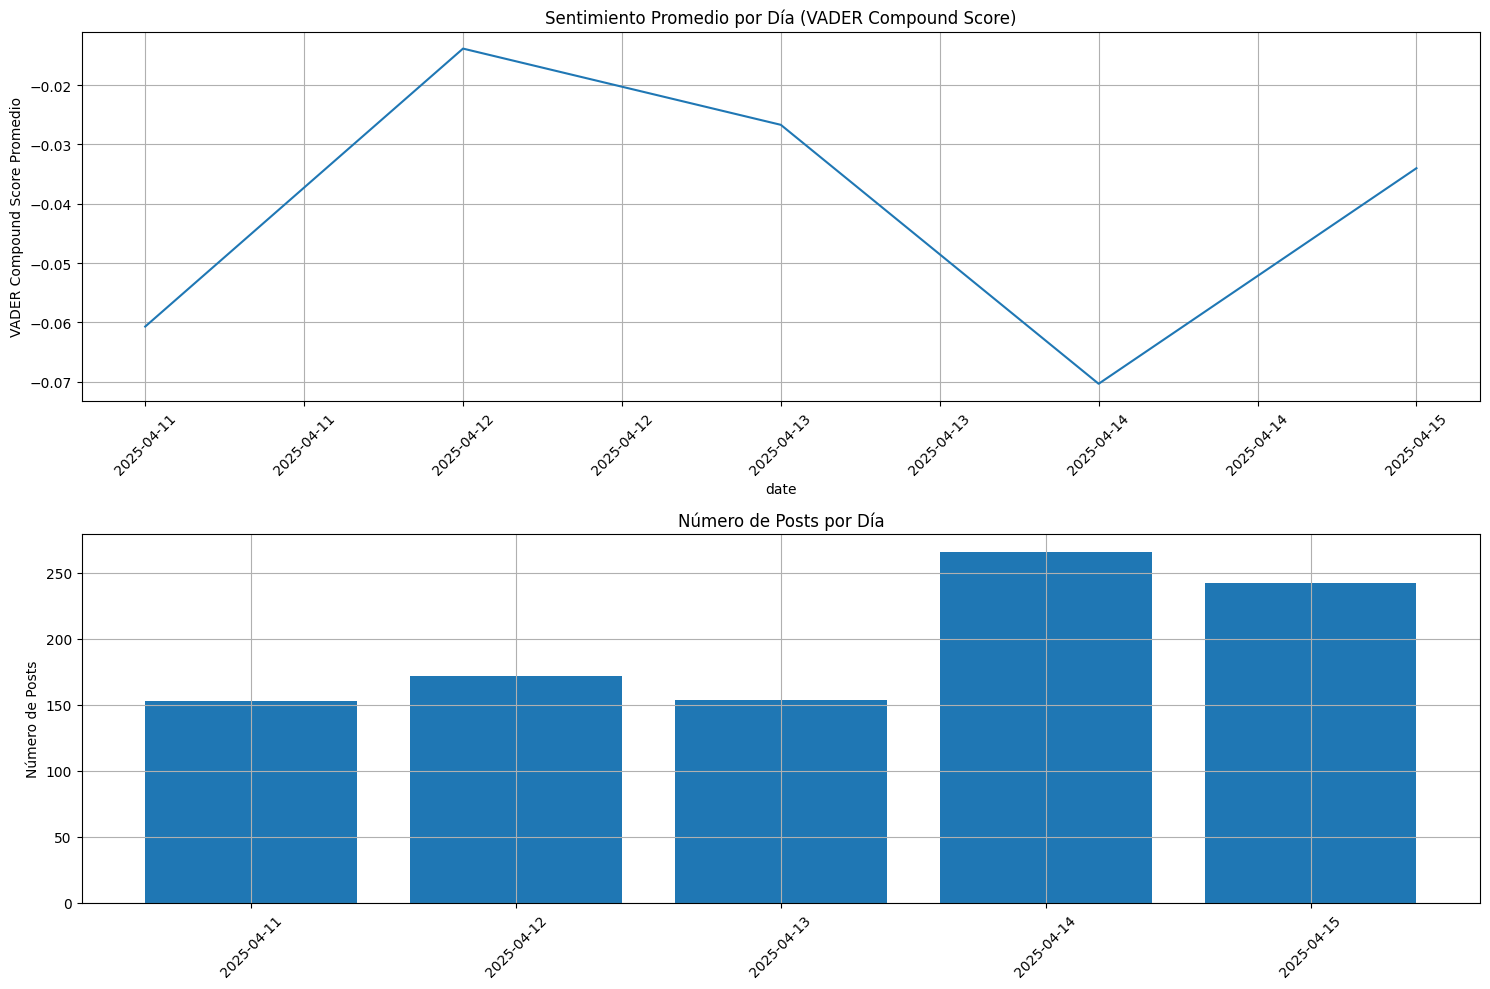

Visualizaciones generadas.

Estadísticas de Sentimiento por Día (VADER):
      date  sentiment_mean  post_count
2025-04-11       -0.060690         153
2025-04-12       -0.013838         172
2025-04-13       -0.026688         154
2025-04-14       -0.070334         266
2025-04-15       -0.034000         242


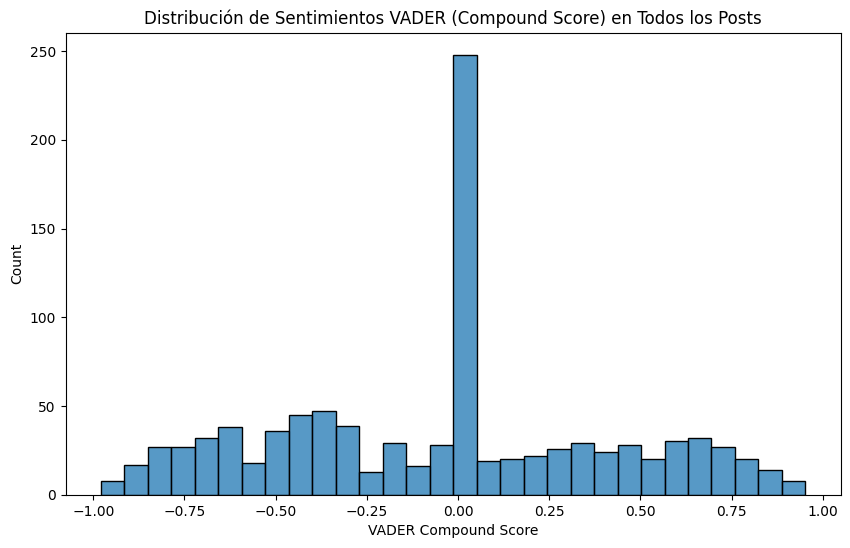


Estadísticas Generales de Sentimiento VADER:
Sentimiento VADER promedio general: -0.043
Posts positivos (VADER >= 0.05): 319
Posts negativos (VADER <= -0.05): 409
Posts neutrales (VADER >-0.05 y <0.05): 259


In [21]:
# --- Celda de Análisis de Sentimiento Diario (con VADER) ---
# Descomenta y ejecuta si no tienes vaderSentiment instalado
# !pip install vaderSentiment

!pip install vaderSentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd # Asegúrate que pandas está importado

# Función para analizar sentimiento diario usando VADER
def analyze_sentiment_by_day_vader(df_input):
    # Crear una copia para evitar modificar el DataFrame original directamente
    df = df_input.copy()

    # Inicializar el analizador VADER
    analyzer = SentimentIntensityAnalyzer()

    # Convertir created_at a fecha (sin hora) si no lo está ya
    if 'date' not in df.columns:
         # Asegurarse que created_at existe y es datetime
         if 'created_at' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['created_at']):
             print("Error: La columna 'created_at' no existe o no es de tipo datetime.")
             return pd.DataFrame() # Devuelve DataFrame vacío en caso de error
         df['date'] = df['created_at'].dt.date

    # Función para calcular el sentimiento VADER (usando 'compound' score)
    def get_vader_sentiment(text):
        try:
            # Obtener el 'compound' score que resume el sentimiento (-1 a +1)
            vs = analyzer.polarity_scores(str(text))
            return vs['compound']
        except:
            return 0 # Devuelve 0 si hay algún error

    # Calcular sentimiento VADER para cada post
    print("Calculando sentimiento VADER para cada post...")
    df['sentiment'] = df['text'].apply(get_vader_sentiment)
    print("Cálculo de sentimiento individual completado.")

    # Agrupar por fecha y calcular estadísticas
    print("Agrupando resultados por día...")
    daily_sentiment = df.groupby('date').agg(
        # Usamos mean para el promedio de scores 'compound' del día
        sentiment_mean=('sentiment', 'mean'),
        post_count=('sentiment', 'size') # size es más directo para contar filas
    ).reset_index()
    print("Agrupación completada.")

    # --- Visualizaciones ---
    print("Generando visualizaciones...")
    plt.figure(figsize=(15, 10))

    # Gráfico 1: Sentimiento promedio (VADER compound) por día
    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    sns.lineplot(data=daily_sentiment, x='date', y='sentiment_mean')
    plt.title('Sentimiento Promedio por Día (VADER Compound Score)')
    plt.ylabel('VADER Compound Score Promedio')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)

    # Gráfico 2: Número de posts por día
    plt.subplot(2, 1, 2)
    ax2 = plt.gca()
    # Convertir fechas a formato matplotlib para plt.bar
    try:
        dates_num = mdates.date2num(daily_sentiment['date'])
        plt.bar(dates_num, daily_sentiment['post_count'])
    except Exception as e:
        print(f"Error al graficar barras de posts por día: {e}. Intentando con seaborn...")
        # Fallback a seaborn si hay problemas con la conversión de fechas para bar
        sns.barplot(data=daily_sentiment, x='date', y='post_count', ax=ax2)

    plt.title('Número de Posts por Día')
    plt.ylabel('Número de Posts')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print("Visualizaciones generadas.")

    # --- Estadísticas y Distribución ---
    print("\nEstadísticas de Sentimiento por Día (VADER):")
    # Asegurar que la columna de fecha se muestra bien
    daily_sentiment_display = daily_sentiment[['date', 'sentiment_mean', 'post_count']].copy()
    daily_sentiment_display['date'] = pd.to_datetime(daily_sentiment_display['date']).dt.strftime('%Y-%m-%d')
    print(daily_sentiment_display.to_string(index=False))

    # Análisis adicional: Distribución de sentimientos VADER
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sentiment', bins=30)
    plt.title('Distribución de Sentimientos VADER (Compound Score) en Todos los Posts')
    plt.xlabel('VADER Compound Score')
    plt.show()

    # Calcular estadísticas generales VADER (usando los mismos umbrales para comparar)
    print("\nEstadísticas Generales de Sentimiento VADER:")
    print(f"Sentimiento VADER promedio general: {df['sentiment'].mean():.3f}")
    # Umbrales VADER estándar: Positive >= 0.05, Negative <= -0.05, Neutral >-0.05 and <0.05
    positive_vader_count = len(df[df['sentiment'] >= 0.05])
    negative_vader_count = len(df[df['sentiment'] <= -0.05])
    neutral_vader_count = len(df[(df['sentiment'] > -0.05) & (df['sentiment'] < 0.05)])
    print(f"Posts positivos (VADER >= 0.05): {positive_vader_count}")
    print(f"Posts negativos (VADER <= -0.05): {negative_vader_count}")
    print(f"Posts neutrales (VADER >-0.05 y <0.05): {neutral_vader_count}")

    return daily_sentiment # Devolvemos el DataFrame agrupado por día

# --- EJECUCIÓN ---
# Decidir qué DataFrame usar para el análisis:
# Si ejecutaste la celda de filtrado y df_filtered existe y no está vacío:
if 'df_filtered' in locals() and isinstance(df_filtered, pd.DataFrame) and not df_filtered.empty:
    print("Ejecutando análisis de sentimiento VADER sobre los posts FILTRADOS...")
    daily_sentiment_df_vader = analyze_sentiment_by_day_vader(df_filtered)
# Si no, usar el DataFrame original 'df'
elif 'df' in locals() and isinstance(df, pd.DataFrame) and not df.empty:
    print("Ejecutando análisis de sentimiento VADER sobre TODOS los posts...")
    daily_sentiment_df_vader = analyze_sentiment_by_day_vader(df)
else:
    print("⚠️ Error: No se encontró un DataFrame 'df' o 'df_filtered' válido para analizar.")
    daily_sentiment_df_vader = pd.DataFrame() # Crear df vacío para evitar errores posteriores


## Aplico método de VADER a cada post

In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

# Inicializar el analizador VADER
analyzer = SentimentIntensityAnalyzer()

# Calcular el sentimiento VADER para cada post
df['sentiment_vader'] = df['text'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Interpretar el sentimiento
POSITIVE_THRESHOLD = 0.05
NEGATIVE_THRESHOLD = -0.05

def interpretar_sentimiento(score):
    if score > POSITIVE_THRESHOLD:
        return 'Positivo'
    elif score < NEGATIVE_THRESHOLD:
        return 'Negativo'
    else:
        return 'Neutral'

df['interpretacion_sentimiento'] = df['sentiment_vader'].apply(interpretar_sentimiento)

In [70]:
print(df.columns.tolist())

['actor_handle', 'uri', 'text', 'created_at', 'likes', 'reposts', 'replies', 'sentiment_vader', 'interpretacion_sentimiento', 'text_length', 'word_count', 'hour', 'engagement', 'date', 'sentiment']


## Muestro el dataframe completo

In [24]:
print("Vista previa del DataFrame con análisis de sentimiento:")
display(df.head())

Vista previa del DataFrame con análisis de sentimiento:


,actor_handle,uri,text,created_at,likes,reposts,replies,text_length,word_count,hour,engagement,date,sentiment,sentiment_vader,interpretacion_sentimiento
0,barchart.com,at://did:plc:uf6xe5actjzjqqglrr5fvu7j/app.bsky...,S&P 500 companies are experiencing the worst e...,2025-04-15 23:58:34.305000+00:00,86,16,2,90,15,23,104,2025-04-15,-1.000000,-0.6249,Negativo
1,theguardian.com,at://did:plc:vovinwhtulbsx4mwfw26r5ni/app.bsky...,The return of the firing squad is a defeat for...,2025-04-15 23:28:41.295000+00:00,89,20,10,86,16,23,119,2025-04-15,0.000000,-0.8555,Negativo
2,nytimes.com,at://did:plc:eclio37ymobqex2ncko63h4r/app.bsky...,Millions of people across Southern California ...,2025-04-15 23:12:31.800000+00:00,1015,149,66,272,42,23,1230,2025-04-15,0.000000,-0.0772,Negativo
3,aoc.bsky.social,at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky...,Thank YOU for coming out!\n\nThis is exactly w...,2025-04-15 23:06:41.062000+00:00,16833,1745,365,296,54,23,18943,2025-04-15,0.175000,0.9259,Positivo
4,theguardian.com,at://did:plc:vovinwhtulbsx4mwfw26r5ni/app.bsky...,British hospitals introduce treatment for hear...,2025-04-15 23:05:06+00:00,270,67,4,79,12,23,341,2025-04-15,-0.158333,-0.0772,Negativo


## Guardo el CSV para que sea procesado por el ETL de ingesta

In [25]:
# Guardar el DataFrame completo con todas las columnas en un CSV
df.to_csv('posts_con_sentimiento.csv', index=False, encoding='utf-8-sig')
print("Archivo 'posts_con_sentimiento.csv' exportado correctamente.")

Archivo 'posts_con_sentimiento.csv' exportado correctamente.
